In [26]:
#第四次个人作业——元培学院 吴振宇 1300017639

#1). 计算 每月简单收益率，计算三个资产的期望收益率，给出最小期望收益率(mumin)和最大期望收益率(mumax)。

#设置环境

import pandas.io.sql as sql
from lxml.html import parse
from urllib.request import urlopen
import pandas as pd
import urllib 
import numpy as np
from matplotlib.pyplot import plot,savefig 
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import statsmodels.api as sm
import scipy.stats as stats 

In [27]:
#编制数据抓取函数: get_sina_stock

def get_sina_stock(stockid,start,end,isstock=True,fuquan=True):    
    def _unpack(row, kind='td'):
        elts = row.findall('.//%s' % kind)
        return [val.text_content().strip() for val in elts]     
    def parse_options_data(table,isstock,fuquan):
        rows = table.findall('.//tr')
        data = [_unpack(r) for r in rows[2:]]
        if isstock & fuquan:
            colnames = ['date','open','high','close','low','vol','amount','ratio'] 
        else:
            colnames = ['date','open','high','close','low','vol','amount']
        data= pd.DataFrame(data,columns=colnames)
        data.index=pd.to_datetime(data["date"])
        data=data.drop("date",axis=1)
        data=data.ix[range(len(data)-1,-1,-1)]
        return  data
    data=pd.DataFrame()
    daterange=pd.date_range(start,end,freq="Q")
    daterange=daterange.insert(len(daterange),daterange[-1]+1)
    for cq in daterange: 
        if isstock:
            if fuquan:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_FuQuanMarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
            else:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)            
        else:            
            url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'/type/S.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
        try:
            parsed = parse(urlopen(url))
        except:
            print ("download failed for year=" +str(cq.year)+',  jidu='+str(cq.month/3))
            continue
        doc = parsed.getroot()
        tables=doc.findall('.//table')     
        da= tables[-1] # last table 19 for fuquan data and 4 for index
        datatem = parse_options_data(da,isstock,fuquan)
        data=pd.concat([data,datatem])
    return pd.DataFrame(data[start:end],dtype=float)    

In [28]:
data1=get_sina_stock("600352",start="2012-1-1",end="2014-12-31").close
data2=get_sina_stock("600109",start="2012-1-1",end="2014-12-31").close
data3=get_sina_stock("601939",start="2012-1-1",end="2014-12-31").close
data1.name='600352'#浙江龙盛
data2.name='600109'#国金证券
data3.name='601939'#建设银行
data=pd.concat([data1,data2,data3],axis=1)

In [29]:
#计算三只股票的月收益率，并观察数据分布

rtn_m=data.resample('M').last().pct_change().dropna()
rtn_m.describe()

,600352,600109,601939
count,35.000000,35.000000,35.000000
mean,0.041254,0.051770,0.018429
std,0.118005,0.159993,0.085140
min,-0.114974,-0.266117,-0.078671
25%,-0.050851,-0.028861,-0.016109
50%,0.016597,0.023841,0.011860
75%,0.105169,0.115781,0.029595
max,0.333341,0.405837,0.431846


In [30]:
Mu=rtn_m.mean().reshape((3,1))
Sigma=rtn_m.cov()
print(Mu)
Sigma

[[ 0.0412535 ]
 [ 0.05177002]
 [ 0.01842906]]


,600352,600109,601939
600352,0.013925,0.002882,0.004900
600109,0.002882,0.025598,0.004577
601939,0.004900,0.004577,0.007249


In [31]:
#线性表出组合收益率

import sympy as sy
from sympy.interactive import printing
printing.init_printing(use_latex=True)

w1=sy.symbols('w1',positive = True, real = True)
w2=sy.symbols('w2',positive = True, real = True)
printing.init_printing(use_latex=True)
mu1=0.02006236;mu2=0.03222985;mu3=0.01471731
ExpRet=sy.simplify(mu1*w1+mu2*w2+mu3*(1-w1-w2))
print("ExpRet of portfolio = ", ExpRet)

ExpRet of portfolio =  0.00534505*w1 + 0.01751254*w2 + 0.01471731


In [32]:
#2). 在有卖空限制和没有卖空限制下分别完成，a) 从最小期望mumin 到  mumax 等距取500个点作为期望收益率，计算相应的有效组合；
#    b) 如果年无风险利率为3%，计算月风险利率，寻找收益率在mumin和mumax之间的sharpe比最大的组合。c) 在std-mean坐标中画出原始资产，有效前沿， sharpe比最大组合和无风险资产。

#根据拉格朗日最大化结果计算关键参数

Sigma=np.matrix(Sigma)
N=len(Mu)
Mu=np.matrix(Mu.reshape(N,1))
onesv=np.matrix(np.ones((N,1)))
SI=Sigma.I
A=Mu.T*SI*onesv; A=A[0,0]
B=Mu.T*SI*Mu; B=B[0,0]
C=onesv.T*SI*onesv; C=C[0,0]
D=B*C-A**2
g=SI*onesv*B/D-SI*Mu*A/D
h=SI*Mu*C/D-SI*onesv*A/D

In [33]:
#计算最小方差组合收益率及方差

mumin=np.min(Mu)
mumax=np.max(Mu)
meanv=np.linspace(mumin,mumax,500)
wv=list(map(lambda x: g+x*h,meanv))
sigmav=list(map(lambda x: np.sqrt(x.T*Sigma*x)[0,0],wv))
mu_mvp=-g.T*Sigma*h/(h.T*Sigma*h)
sigma_mvp=np.sqrt(g.T*Sigma*g-(g.T*Sigma*h)**2/(h.T*Sigma*h))

In [34]:
rf_y=0.03
muf=round(1/12*rf_y,6)

wt=SI*(Mu-muf)
wt=wt/(onesv.T*wt)
mut=wt.T*Mu
sigmat=np.sqrt(wt.T*Sigma*wt)

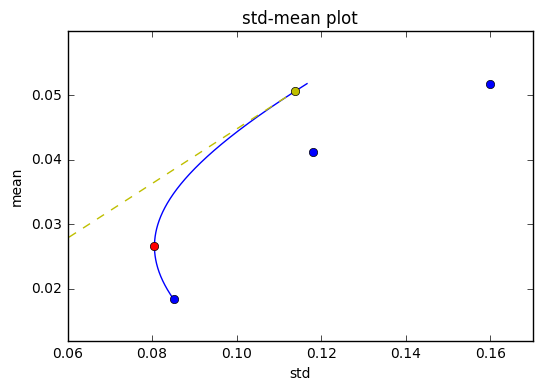

In [35]:
#画出std-mean图像，并设置图像参数

%matplotlib inline

Sig=rtn_m.std()
plt.plot(sigmav,meanv)
plt.plot(Sig,Mu,"bo")
plt.plot(sigma_mvp,mu_mvp,"ro")
plt.plot([0,sigmat.item(0)],[muf,mut.item(0)],"yo--")

plt.xlim([0.06,0.17]) 
plt.ylim([0.012,0.06])
plt.xlabel('std')
plt.ylabel('mean')
plt.title('std-mean plot')

In [11]:
#计算组合方差

def calc_portfolio_std(returns=None,sigma=None, weights=None):
    if weights is None: 
        weights = np.ones(returns.columns.size) / \
        returns.columns.size
    if returns is not None:
        sigma = returns.cov()
    ## the the same result as the  matrix dot
    var = weights.dot(sigma).dot(weights)
    return np.sqrt(var)

In [12]:
import scipy.optimize as scopt 
def objfunvar(W, R, target_ret):
    cov=np.cov(R.T) 
    port_var = np.dot(np.dot(W,cov),W.T) 
    return np.sqrt(port_var)

In [13]:
#用函数计算允许卖空和禁止卖空条件下的有效前沿

def calc_efficient_frontier(returns,sellshort=True):
    result_means = []
    result_stds = []
    result_weights = []
    
    means = returns.mean()
    min_mean, max_mean = means.min(), means.max()
    
    nstocks = returns.columns.size
    if sellshort:
        bounds=None
    else:
        bounds = [(0,1) for i in np.arange(nstocks)]
    for r in np.linspace(min_mean, max_mean, 500):
        weights = np.ones(nstocks)/nstocks        
        constraints = ({'type': 'eq', 
                        'fun': lambda W: np.sum(W) - 1},
                      {'type': 'eq', 
                        'fun': lambda W: np.sum(W*means) -r})
        results = scopt.minimize(objfunvar, weights, (returns, r), 
                                 method='SLSQP', 
                                 constraints = constraints,
                                 bounds = bounds)
        if not results.success: # handle error
            raise Exception(results.message)
        result_means.append(np.round(r,6)) # 6 decimal places
        #std_=np.round(np.std(np.sum(returns*results.x,axis=1)),6)
        std_=objfunvar(results.x,returns,r)
        result_stds.append(std_)        
        result_weights.append(np.round(results.x, 6))
    return {'Means': result_means, 
            'Stds': result_stds, 
            'Weights': result_weights}

In [14]:
x=calc_efficient_frontier(rtn_m)
x1=calc_efficient_frontier(rtn_m,sellshort=False)

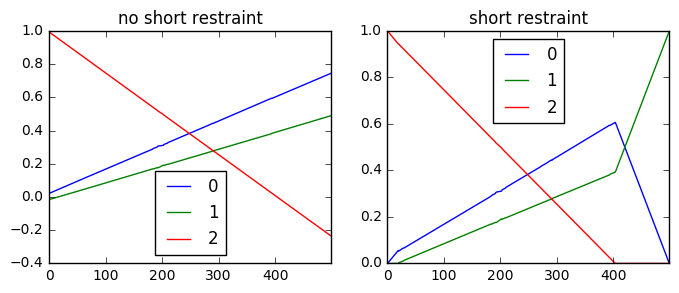

In [15]:
#画出允许卖空和禁止卖空条件下的资产权重变化

plt.figure(figsize=(8, 3))
ax1=plt.subplot(121)
pd.DataFrame(x['Weights']).plot(ax=ax1,title="no short restraint")
ax2=plt.subplot(122)
pd.DataFrame(x1['Weights']).plot(ax=ax2,title="short restraint")

In [16]:
#求解切点组合

def negative_sharpe_ratio( weights,means,sig,risk_free_rate = 0.015):
    # get the portfolio variance
    std = calc_portfolio_std(sigma=sig, weights=weights)  
    # and return the sharpe ratio
    return -((means.dot(weights) - risk_free_rate)/(std))

In [17]:
def optimize_portfolio(returns, risk_free_rate,sellshort=True):
    """ 
    Performs the optimization
    """
    means=returns.mean()
    sig=returns.cov()
    if sellshort:
        bounds=None
    else:
        bounds = [(0,1) for i in np.arange(returns.columns.size)]
        
    weights = np.ones(returns.columns.size, 
                 dtype=float) * 1.0 / returns.columns.size
    # minimize the negative sharpe value
    
    
    constraints = ({'type': 'eq', 
                        'fun': lambda W: np.sum(W) - 1})
    results = scopt.minimize(negative_sharpe_ratio, weights, (means,sig, risk_free_rate), 
                                 method='SLSQP', 
                                 constraints = constraints,
                                 bounds = bounds)
    if not results.success: # handle error
        raise Exception(results.message)
    mean_sharpe=results.x.dot(means)    
    std_sharpe=calc_portfolio_std(sigma=sig,weights=results.x)
    return {'Means': mean_sharpe, 
            'Stds': std_sharpe, 
            'Weights': results.x}

In [18]:
T=optimize_portfolio(rtn_m,muf ,sellshort=False)
T

{'Means': 0.045494326347371453,
 'Stds': 0.1025105205934979,
 'Weights': array([  5.96746233e-01,   4.03253767e-01,   2.75387352e-17])}

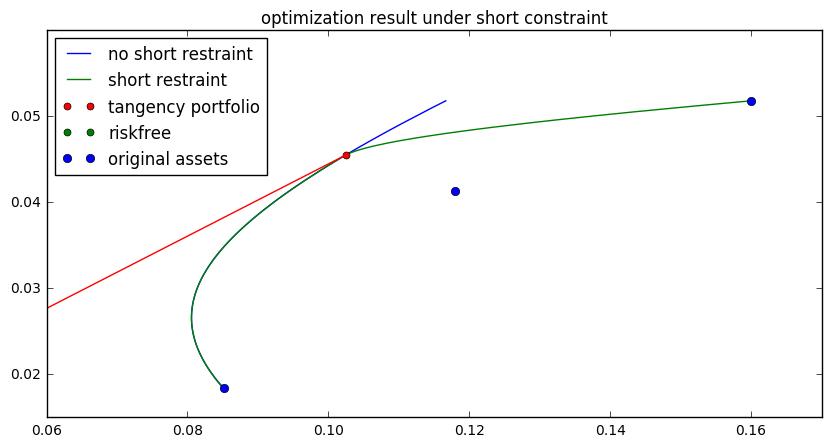

In [19]:
#画出所需图像

plt.figure(figsize=(10,5))
plt.plot(x["Stds"],x["Means"],label="no short restraint")
plt.plot(x1["Stds"],x1["Means"],label="short restraint")
plt.plot(T["Stds"],T["Means"],"ro",markersize=5,label="tangency portfolio")
plt.plot(0,muf,"go",markersize=5,label="riskfree")
plt.plot([0,T["Stds"]],[muf,T["Means"]])
plt.plot(Sig,Mu,"bo",label="original assets")
plt.xlim(0.06,0.17)
plt.ylim(0.015,0.06)
plt.legend(loc='upper left')
plt.title('optimization result under short constraint')

In [20]:
#3). 找到在限制卖空条件下，2)--a) 中500个点的最小方差组合，记为组合1。考虑同样资产 2015.1--2016.10间的月收益率，找到限制卖空条件下的
#    最小方差组合，记为组合2。 在同一个时间-收益率坐标中 画出组合1和组合2在2015.1--2016.10 间的月收益率曲线。
#    比较两个组合对应收益率的统计特征(期望，方差，最大值，最小值，中位数)。你觉得这两个收益率分布两者差异大吗？

#组合1的权重
weights_mvp=x1['Weights'][x1['Stds'].index(min(x1['Stds']))]
weights_mvp

array([ 0.200351,  0.107333,  0.692316])

In [21]:
#按同样流程找到组合2

data1_new=get_sina_stock("600352",start="2014-12-31",end="2016-10-31").close
data2_new=get_sina_stock("600109",start="2014-12-31",end="2016-10-31").close
data3_new=get_sina_stock("601939",start="2014-12-31",end="2016-10-31").close
data1_new.name='600352'#浙江龙盛
data2_new.name='600109'#国金证券
data3_new.name='601939'#建设银行
data_new=pd.concat([data1_new,data2_new,data3_new],axis=1)
rtn_m_new=data_new.resample('M').last().pct_change().dropna()
rtn_m_new.describe()

,600352,600109,601939
count,22.000000,22.000000,22.000000
mean,0.009788,-0.003851,-0.003179
std,0.156517,0.163513,0.082636
min,-0.331617,-0.316803,-0.167858
25%,-0.112042,-0.079272,-0.051839
50%,0.012751,0.010654,0.008706
75%,0.104280,0.048859,0.056645
max,0.288186,0.269127,0.122923


In [22]:
#组合2的权重

x1_new=calc_efficient_frontier(rtn_m_new,sellshort=False)
weights_mvp_new=x1_new['Weights'][x1_new['Stds'].index(min(x1_new['Stds']))]
weights_mvp_new

array([ 0.097829,  0.      ,  0.902171])

In [23]:
#计算出两个组合在2015-1-1到2016-10-31期间的收益率并做简单统计描述

a=rtn_m_new*weights_mvp
b=rtn_m_new*weights_mvp_new
port_rtn=pd.DataFrame([[sum(a.ix[x]) for x in range(0,22)],[sum(b.ix[x]) for x in range(0,22)]],index=['portfolio1','portfolio2']).T
port_rtn.index=rtn_m_new.index
port_rtn.describe()

,portfolio1,portfolio2
count,22.000000,22.000000
mean,-0.000653,-0.001910
std,0.088140,0.081382
min,-0.215409,-0.183878
25%,-0.027169,-0.045310
50%,0.014490,0.002848
75%,0.056419,0.067397
max,0.135347,0.113368


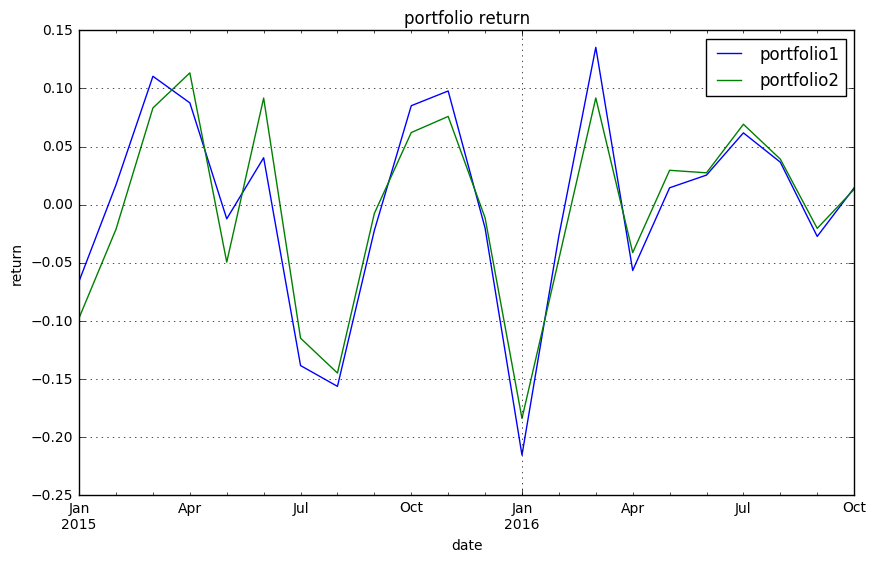

In [24]:
#画出图像

port_rtn.plot(figsize=(10,6),title='portfolio return',grid=True)
plt.xlabel('date')
plt.ylabel('return')

In [25]:
#比较图像和描述统计中的参数，发现两个组合在同一时间段内表现非常接近，无显著差异。